In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import torch

from inference.train import train
from inference.plannar import NormalizingFlow
from simulate.simulate import simulate
from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from data.get_experimental_data import get_experimental_data

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
data = get_experimental_data("../../data/data_character_meaning.csv")

number of user 53
number of items 1998
total number of observations (excluding first presentation) 70618
minimum number of observation for a single user 1285
maximum number of observation for a single user 1404


In [4]:
df_param = pd.read_csv("bkp/param_exp_data.csv", index_col=0)
df_param

,mu1,sigma_u1,sigma_w1,mu2,sigma_u2,sigma_w2
unconstrained,-5.661843,1.844262,1.616331,-0.723793,1.720237,1.218074


In [5]:
class Leitner:

    def __init__(self, env,  delay_factor=2, delay_min=4):

        self.n_item = env.n_item

        self.delay_factor = delay_factor
        self.delay_min = delay_min

        self.box = np.full(self.n_item, -1)
        self.due = np.full(self.n_item, -1)

    def update_box_and_due_time(self, last_idx,
                                last_was_success, last_time_reply):

        if last_was_success:
            self.box[last_idx] += 1
        else:
            self.box[last_idx] = \
                max(0, self.box[last_idx] - 1)

        delay = self.delay_factor ** self.box[last_idx]
        # Delay is 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 ...
        self.due[last_idx] = \
            last_time_reply + self.delay_min * delay

    def _pickup_item(self, now):

        seen = np.argwhere(np.asarray(self.box) >= 0).flatten()
        n_seen = len(seen)

        if n_seen == self.n_item:
            return np.argmin(self.due)

        else:
            seen__due = np.asarray(self.due)[seen]
            seen__is_due = np.asarray(seen__due) <= now
            if np.sum(seen__is_due):
                seen_and_is_due__due = seen__due[seen__is_due]

                return seen[seen__is_due][np.argmin(seen_and_is_due__due)]
            else:
                return self._pickup_new()

    def _pickup_new(self):
        return np.argmin(self.box)

    def ask(self, now, last_was_success, last_time_reply, idx_last_q):

        if idx_last_q is None:
            item_idx = self._pickup_new()

        else:

            self.update_box_and_due_time(
                last_idx=idx_last_q,
                last_was_success=last_was_success,
                last_time_reply=last_time_reply)
            item_idx = self._pickup_item(now)

        return item_idx

    def act(self, obs):

        """
        Adaptation for RL env
        """

        # TODO: Adapt the code

In [6]:
class DummyEnv:
    def __init__(self, n_item):
        self.n_item = n_item


def simulate_human_like(
        df_param,
        n_u=53,
        n_w=1998,
        n_ss=6,
        n_iter_per_session=100,
        space_between_session=24*60**2,
        time_per_iter=3,
        use_torch=True,
        seed=0):

    np.random.seed(seed)
    
    mu = np.array([df_param.loc["unconstrained", f"mu{i}"] for i in range(1, 3)])
    sg_u = np.array([df_param.loc["unconstrained", f"sigma_u{i}"] for i in range(1, 3)])
    sg_w = np.array([df_param.loc["unconstrained", f"sigma_w{i}"] for i in range(1, 3)])
    
    Zu = np.random.normal(np.zeros(2), sg_u, size=(n_u, 2))
    Zw = np.random.normal(np.zeros(2), sg_w, size=(n_w, 2))
    
    break_length = space_between_session - time_per_iter * n_iter_per_session
    
    n_obs = n_iter_per_session*n_ss*n_u
    
    Z_sample = np.zeros((n_obs, 2))
    
    u = np.zeros(n_obs)
    w = np.zeros(n_obs)
    r = np.zeros(n_obs)
    x = np.zeros(n_obs)
    y = np.zeros(n_obs)
    
    i = 0
    
    for user in range(n_u):
        
        env = DummyEnv(n_item=n_w)
        teacher = Leitner(env)
        
        last_was_success = None
        last_time_reply = None
        idx_last_q = None
        
        rep = np.full(n_w, -1, dtype=int)
        last_pres = np.full(n_w, -np.inf)
        
        t = 0
        
        for session in range(n_ss):
            for iteration in range(n_iter_per_session):
                
                item = teacher.ask(
                    now=t, 
                    last_was_success=last_was_success, 
                    last_time_reply=last_time_reply,
                    idx_last_q=idx_last_q)
                
                delta_last_pres = t - last_pres[item]
                rep_item = rep[item]
                
                Za = mu[0] + Zu[user, 0] + Zw[item, 0]
                Zb = mu[1] + Zu[user, 1] + Zw[item, 1]
                
                a = np.exp(Za)
                b = scipy.special.expit(Zb)
                
                neg_rate = - a * delta_last_pres * (1 - b) ** rep_item
                p = np.exp(neg_rate)
                recall = p > np.random.random()
                
                u[i] = user
                w[i] = item
                r[i] = rep_item
                x[i] = delta_last_pres
                y[i] = recall

                Z_sample[i] = Za, Zb
                
                rep[item] += 1
                last_pres[item] = t

                
                i += 1
                
                if iteration == n_iter_per_session - 1:
                    t += break_length
                else:
                    t += time_per_iter
                    
    to_keep = r[:] >= 0
    
    u = u[to_keep]
    w = w[to_keep]
    r = r[to_keep]
    x = x[to_keep]
    y = y[to_keep]
                    
    data = {'u': u, 'w': w,
            'x': x, 'r': r,
            'y': y}
    
    Z_sample = Z_sample[to_keep]

    sg_u_sample = np.std(Zu, axis=0)
    sg_w_sample = np.std(Zw, axis=0)
    mu_sample = np.mean(Z_sample, axis=0)
    truth = {
        'mu': mu, 'sg_u': sg_u, 'sg_w': sg_w,
        'mu_smp': mu_sample, 'sg_u_smp': sg_u_sample, 'sg_w_smp': sg_w_sample}

    if use_torch:
        data = {
            'x': torch.from_numpy(data['x'].reshape(-1, 1)),
            'y': torch.from_numpy(data['y'].reshape(-1, 1)),
            'r': torch.from_numpy(data['r'].reshape(-1, 1)),
            'u': data['u'],
            'w': data['w']}

    return data, truth

In [7]:
data, truth = simulate_human_like(df_param=df_param, use_torch=True)

In [ ]:
run_name = "artificial_human_like"
z_flow, theta_flow, hist_loss = train(
    data,
    initial_lr=0.0001,
    flow_length=40,
    optimizer_name="RMSprop",
    n_sample=40,
    epochs=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
z_flow.save(f"z_flow_{run_name}")
theta_flow.save(f"theta_flow_{run_name}")
# z_flow = NormalizingFlow.load("z_flow_artificial")
# theta_flow = NormalizingFlow.load(f"theta_flow_{run_name}")

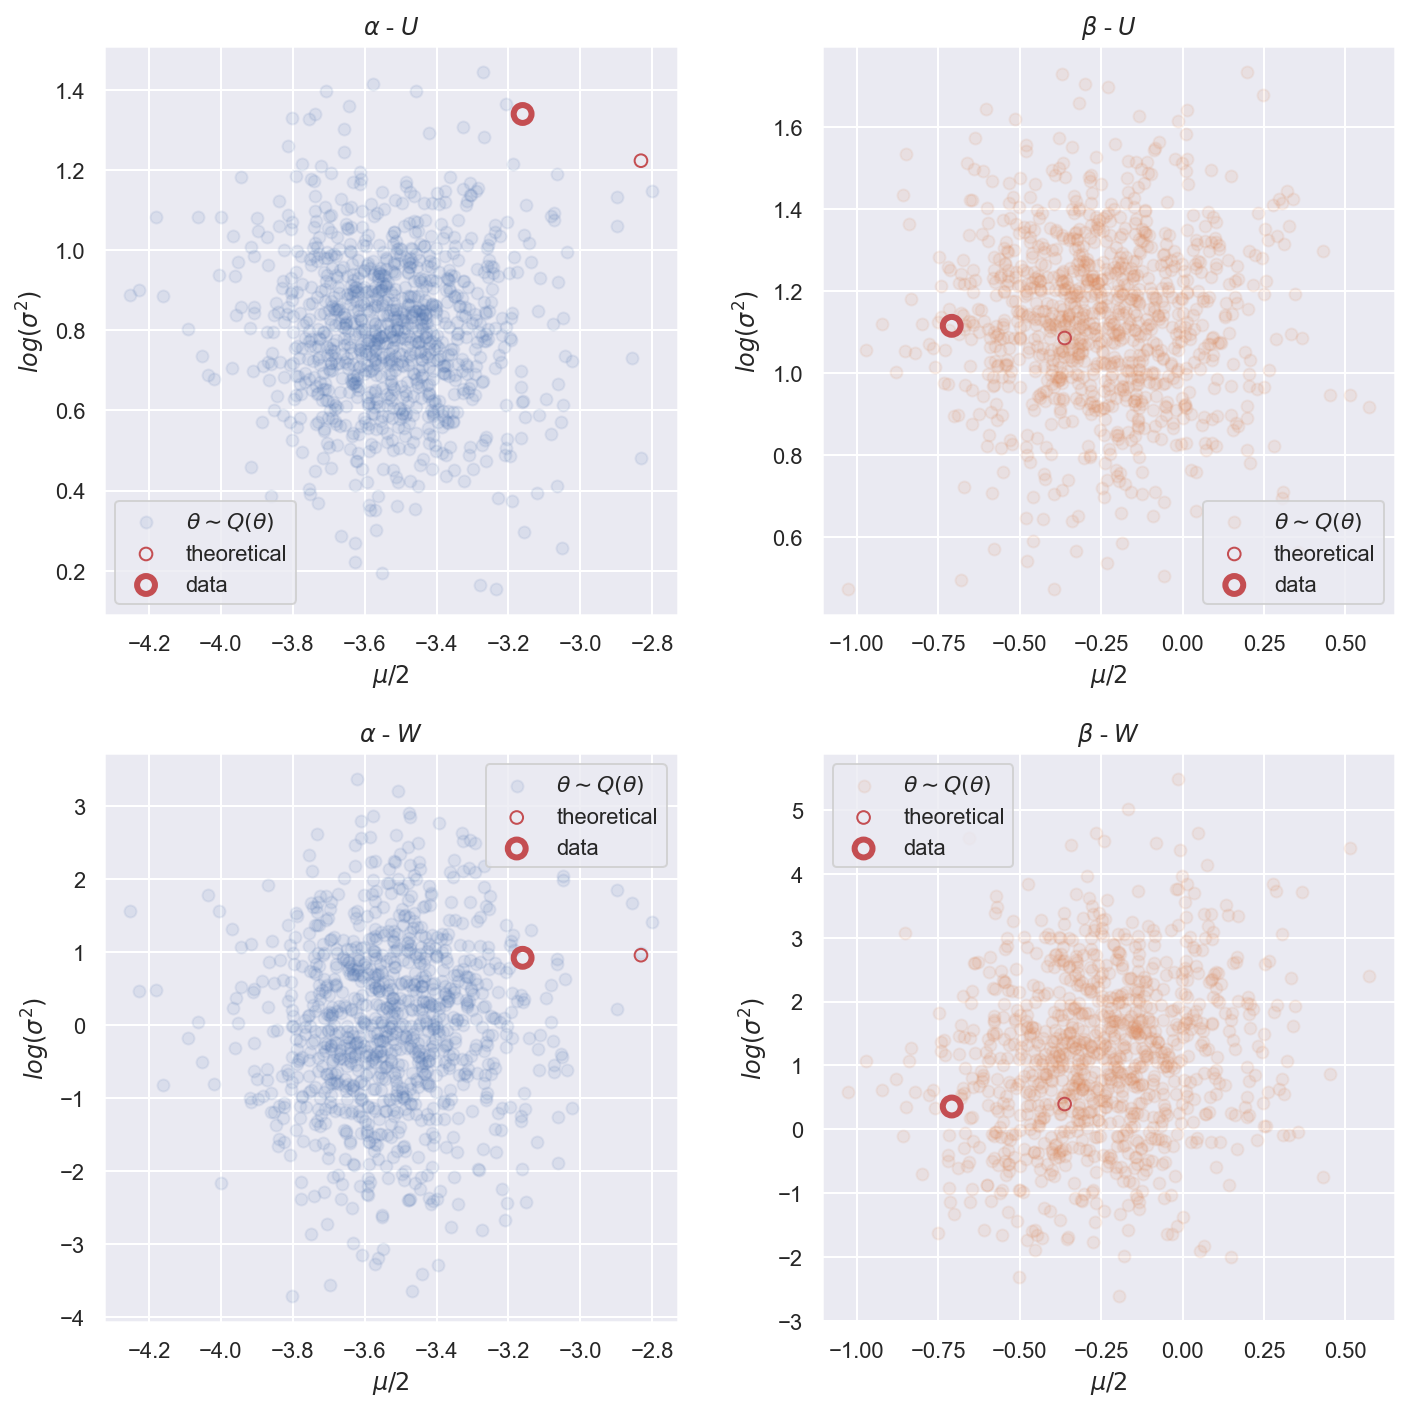

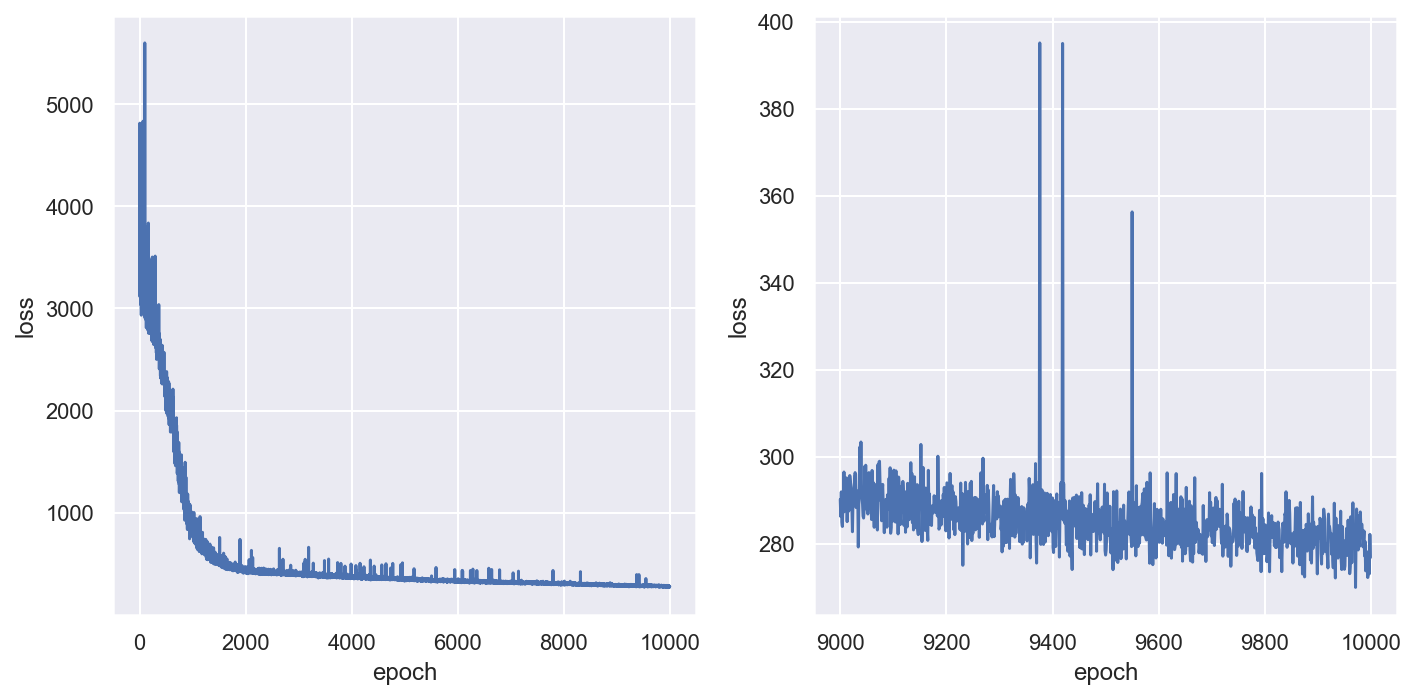

In [11]:
plot_posterior(theta_flow=theta_flow,
               truth=truth,
               name=run_name)
plot_loss(hist_loss=hist_loss, name=run_name)